## 作業
在鐵達尼資料集中，
透過進階補值方法 KNN，將鐵達尼號中的 Titanic_train.csv 中的 Age 的遺失值進行補值。    
* Step1: 觀察 Age 和 Pclass 與 Sex 是否有關連性?
* Step2: 如果有關連性，運用 KNN ，取出 Age 、 Pclass、 Sex的資料，以 Sex 與 Pclass 補 Age 遺失值。 

In [1]:
# import library
import numpy as np
import pandas as pd
from scipy import stats
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

## 讀入資料

In [2]:
df_train = pd.read_csv( 'Titanic_train.csv' )
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# 檢查訓練資料集中是否有遺失值 ?
def Missing_Counts( Data ) : 
    missing = Data.isnull().sum()  
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True ) 
    
    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } ) 
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

Missing_Counts(df_train)

,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


## 觀察 Age

In [4]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

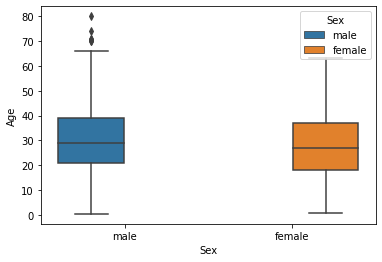

In [5]:
plt.subplots( )
sns.boxplot( x='Sex', y='Age', hue='Sex', data=df_train )
plt.legend( title='Sex', loc='upper right' )
plt.show()

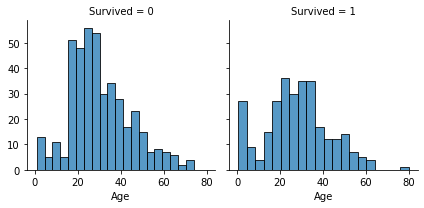

In [6]:
g = sns.FacetGrid( df_train, col='Survived' )
g.map( sns.histplot, 'Age', bins=20 )
plt.show()

- 男性的平均年齡較女性高；
- 0 ~ 4 歲及 76 ~ 80 歲的乘客存活機率較高。

## Step 1: Age 和 Pclass 與 Sex 是否有關連性?

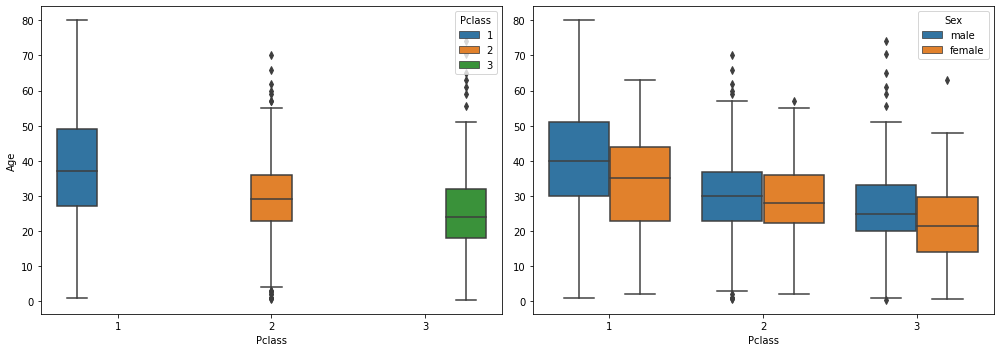

In [7]:
fig = plt.figure( figsize=(14,5) )

ax1 = fig.add_subplot(121)
g = sns.boxplot( x='Pclass', y='Age', hue='Pclass',data=df_train, ax=ax1 )
plt.legend( title='Pclass', loc='upper right' )

ax2 = fig.add_subplot(122)
g = sns.boxplot( x='Pclass', y='Age', hue='Sex', data=df_train, ax=ax2 )
plt.ylabel( '' )

plt.tight_layout()

- 乘客的平均年齡在 Pclass 1 中最高，Pclass 3 中最低。
- 在每個 Pclass 中，男性的平均年齡皆高於女性。  

## Step 2: 如果有關連性，運用 KNN，取出 Age、Pclass、Sex 的資料，以 Sex 與 Pclass 補 Age 遺失值。

In [8]:
data = df_train[['Age','Pclass','Sex']]
data

,Age,Pclass,Sex
0,22.0,3,male
1,38.0,1,female
2,26.0,3,female
3,35.0,1,female
4,35.0,3,male
...,...,...,...
886,27.0,2,male
887,19.0,1,female
888,NaN,3,female
889,26.0,1,male


In [9]:
# Male 轉成 1、FeMale 轉成 0

from sklearn import preprocessing

data_copy = data.copy() #複製一份資料

le = preprocessing.LabelEncoder()
data_copy[ 'Label_Sex' ] = le.fit_transform( data_copy['Sex'] )
data_copy

,Age,Pclass,Sex,Label_Sex
0,22.0,3,male,1
1,38.0,1,female,0
2,26.0,3,female,0
3,35.0,1,female,0
4,35.0,3,male,1
...,...,...,...,...
886,27.0,2,male,1
887,19.0,1,female,0
888,NaN,3,female,0
889,26.0,1,male,1


### 透過 KNN 進行補值¶

In [10]:
from sklearn.impute import KNNImputer

# 欄位名稱( 排除非數值型態的欄位 )
column_names = [ cn for cn in data_copy.columns.tolist() if cn!='Sex' ]
column_names

# 初始化( Initialize KNNImputer )
# 設定 k 值( =1 )
value_neighbors = 1
imputer = KNNImputer( n_neighbors=value_neighbors )

# KNN 補植
df_filled_1 = pd.DataFrame( imputer.fit_transform( data_copy[column_names] ) )
df_filled_1.columns = column_names
df_filled_1

,Age,Pclass,Label_Sex
0,22.0,3.0,1.0
1,38.0,1.0,0.0
2,26.0,3.0,0.0
3,35.0,1.0,0.0
4,35.0,3.0,1.0
...,...,...,...
886,27.0,2.0,1.0
887,19.0,1.0,0.0
888,26.0,3.0,0.0
889,26.0,1.0,1.0


In [11]:
# 確認皆已補值

Missing_Counts(df_filled_1)

,ColumnName,MissingCount,Percentage(%)


In [12]:
# 初始化( Initialize KNNImputer )
# 設定 k 值( =2 )
value_neighbors = 2
imputer = KNNImputer( n_neighbors=value_neighbors )

# KNN 補植
df_filled_2 = pd.DataFrame( imputer.fit_transform( data_copy[column_names] ) )
df_filled_2.columns = column_names
df_filled_2

,Age,Pclass,Label_Sex
0,22.0,3.0,1.0
1,38.0,1.0,0.0
2,26.0,3.0,0.0
3,35.0,1.0,0.0
4,35.0,3.0,1.0
...,...,...,...
886,27.0,2.0,1.0
887,19.0,1.0,0.0
888,26.5,3.0,0.0
889,26.0,1.0,1.0


In [13]:
# 確認皆已補值

Missing_Counts(df_filled_2)

,ColumnName,MissingCount,Percentage(%)
